# **Homework 5 - USA Airport Flight Analysis**

*Group#12*

- **Marco Zimmatore** - [zimmatore.1947442@studenti.uniroma1.it](mailto:zimmatore.1947442@studenti.uniroma1.it)
- **Davide Vitale** - [vitale.1794386@studenti.uniroma1.it](mailto:vitale.1794386@studenti.uniroma1.it)
- **Darkhan Maksutov** - [maksutov.2113209@studenti.uniroma1.it](mailto:maksutov.2113209@studenti.uniroma1.it)
- **Riccardo Soleo** - [soleo.1911063@studenti.uniroma1.it](mailto:soleo.1911063@studenti.uniroma1.it)

___

In [1]:
import functions
import pandas as pd
import numpy as np 
from IPython.display import display, Markdown
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppress all warnings
warnings.filterwarnings("ignore")
dataset_path = "../archive/Airports2.csv"       

In [2]:
df = pd.read_csv('data/Airports2.csv')
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


> We wanna build a graph with edges for each route, where each node represents an airport and eac edge is the existent route between two airports, with all the infos on that route. For this reason, we decide to remove all the rows with *NA* values in them, because each information is crucial for the next exercises computations.

> We remove also all the flights that have $Distance = 0$, because they dont make sense for our next exercises.

In [3]:
df = df.dropna()
df = df[df['Distance'] > 0]
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002
5,MFR,RDM,"Medford, OR","Bend, OR",11,18,1,156,1990-03-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


> We print the data types of the columns

In [4]:
print(df.shape)
df.dtypes

(3588781, 15)


Origin_airport             object
Destination_airport        object
Origin_city                object
Destination_city           object
Passengers                  int64
Seats                       int64
Flights                     int64
Distance                    int64
Fly_date                   object
Origin_population           int64
Destination_population      int64
Org_airport_lat           float64
Org_airport_long          float64
Dest_airport_lat          float64
Dest_airport_long         float64
dtype: object

> Before storing the dataframe into a Graph, we wanna decide if the graph has to be directed or undirected. For this reason we compute the number of *Bidirectional* routes compared to the number of *Unidirectional* routes. 

We have obviously also to consider the purpose of this Graph. 
In our case, it's more convenient to use a *Directed Graph*, since in the next exercises we will compute the *smallest Path* and we wanna filter our edges based of the day of the flights. 

In [5]:
# Create a copy of the dataframe
df_undirected_edges = df[['Origin_airport', 'Destination_airport']].copy()

# Create a normalized key to represent bidirectional routes
df_undirected_edges['normalized_key'] = df.apply(
    lambda row: tuple(sorted([row['Origin_airport'], row['Destination_airport']])), axis=1
)

# Add a column to represent the actual direction of the route
df_undirected_edges['direction'] = df.apply(
    lambda row: (row['Origin_airport'], row['Destination_airport']), axis=1
)

# Add a column to represent the reverse direction of the route
df_undirected_edges['reverse_direction'] = df.apply(
    lambda row: (row['Destination_airport'], row['Origin_airport']), axis=1
)

# Group by normalized_key and collect all directions and reverse directions
grouped_undirected = df_undirected_edges.groupby('normalized_key').agg(
    directions=('direction', list),  # List of all actual directions
    reverse_directions=('reverse_direction', list)  # List of all reverse directions
).reset_index()

# Check if both directions exist for each route
grouped_undirected['is_bidirectional'] = grouped_undirected.apply(
    lambda row: 1 if any(d in row['reverse_directions'] for d in row['directions']) else 0, axis=1
)
# We compute the Percentage between bidirectional and unidirectiona routes
grouped_undirected['is_bidirectional'].value_counts() * 100 / grouped_undirected.shape[0]

is_bidirectional
1    60.557028
0    39.442972
Name: count, dtype: float64

> Since the Number of Bidirectional routes is not too high compared to the Unidirectional Routes, we can proceed using a **Directed Graph** module in *NetworkX*.
___

## **Flight Network Analysis (Q1)**
___

Before going deep in the exercises, we store the Dataframe in a Graph.

**Function** `create_airport_graph`

- The function `create_airport_graph(df)` creates a directed graph using the **Networkx** library from a DataFrame containing airports and flight data.

- For the reasons explained above, we decide to use a **DiGraph** structure because we want to store only 2 connections per route at max. 

- For each row in the DataFrame, it adds two nodes (representing the origin and destination airports) to the graph, along with attributes such as city, population, latitude, and longitude.

-  It then adds a directed edge between the origin and destination airports, with attributes like the number of passengers, flights, seats, **weight as distance**, and flight date.

In [6]:
graph = functions.create_airport_graph(df)
print(graph)

DiGraph with 483 nodes and 34531 edges


> We can notice that only a subset of all the connections have been stored, since the *NetworkX* *DiGraph* structure allows only two edges per route at max.

**Remark**: all the functions displayed and explained below in the $Q_1$, will be runned in the last section (to generate the report), in order to be tidier and not to be too verbose, so that the report can be understood without ripetitions.
___

1. Implement a function `analyze_graph_features(flight_network)` that takes the flight network as input and computes the following:

    - Count the number of airports (`nodes`) and flights (`edges`) in the graph.

    - Compute the density of the graph using the formula: $ Density = \frac{2\times E}{N(N − 1)}$

    - Calculate both `in-degree` and `out-degree` for each airport and visualize them using histograms.

    - Identify airports with degrees higher than the 90th percentile and list them as "`hubs`".
    
    - Determine if the graph is sparse or dense based on its density.



**Function** `analyze_graph_features(flight_network)` 

- It counts the total number of nodes (airports) and edges (flight routes) in the graph iterating over the number of the nodes and the edges to calculate the *in-degrees* and *out_degrees* of each node and storing them into a dictionary.

- It calculates the graph density, which is the ratio of the actual number of edges to the maximum possible number of edges in a directed graph with the same number of nodes. Since we are using a **Directed Graph** the formula used is: $$Density = \frac{\text{Number of Edges}}{\text{Number of nodes} \times (\text{Number of nodes} - 1)}$$ 

- Then we create two Histograms using **Plotly**, one for *in-degrees* and one for *out-degrees*

- It calculates the 90th percentile of the total degree (sum of in-degree and out-degree) across all nodes. Nodes that have a degree higher than this percentile are considered "**hubs**" (highly connected airports).

- In the end, it checks whether the graph is dense or sparse based on the calculated graph density. If the density is greater than a threshold (0.5), the graph is considered dense, otherwise it is sparse.
​


In [7]:
def analyze_graph_features(flight_network):
    # Initialize variables to store the number of nodes and edges
    number_of_nodes = 0
    number_of_edges = len(flight_network.edges())  # Count the number of edges in the graph
    dict_degrees_edges = dict()  # Create an empty dictionary to store in-degrees and out-degrees for each node

    # Iterate over each node in the flight network
    for node in flight_network.nodes:
        number_of_nodes = number_of_nodes + 1  # Increment the node count

        in_edges = 0  # Initialize in-degree counter
        out_edges = 0  # Initialize out-degree counter

        # Count the outgoing edges from the current node
        for _, _, attr in flight_network.edges(node, data=True):
            out_edges += 1

        # Count the incoming edges to the current node
        for _, _, attr in flight_network.in_edges(node, data=True):
            in_edges += 1

        # Store the in-degree and out-degree for the current node in the dictionary
        dict_degrees_edges[node] = [in_edges, out_edges]

    # Calculate graph density using the formula
    graph_density = (number_of_edges) / (number_of_nodes * (number_of_nodes - 1))

    # Extract the in-degrees and out-degrees from the dictionary for histogram plotting
    in_degrees = [edge_degree[0] for edge_degree in dict_degrees_edges.values()]
    out_degrees = [edge_degree[1] for edge_degree in dict_degrees_edges.values()]

    # Create a subplot with 1 row and 2 columns to display histograms for in-degrees and out-degrees
    fig = make_subplots(rows=1, cols=2, subplot_titles=('In-degree Histogram', 'Out-degree Histogram'))

    # Add in-degree histogram to the first subplot (left)
    fig.add_trace(
        go.Histogram(x=in_degrees, nbinsx=20, name='In-degree', marker=dict(color='steelblue')),
        row=1, col=1
    )

    # Add out-degree histogram to the second subplot (right)
    fig.add_trace(
        go.Histogram(x=out_degrees, nbinsx=20, name='Out-degree', marker=dict(color='darkorange')),
        row=1, col=2
    )

    # Update layout for better aesthetics
    fig.update_layout(
        title="In-degree vs Out-degree Histograms",  # Set the title of the plot
        xaxis_title="Degree",  # Label for x-axis
        yaxis_title="Frequency",  # Label for y-axis
        showlegend=True,  # Display legend
        height=500,  # Adjust the height of the figure
        width=1000   # Adjust the width of the figure
    )

    # Calculate the 90th percentile for the total degrees (in-degree + out-degree) of each node

    # Build a dictionary to compute the total degree value (in-degree + out-degree) for each node
    dict_degrees = dict()

    # Iterate over the nodes and calculate the total degree for each
    for node, degrees in dict_degrees_edges.items():
        dict_degrees[node] = degrees[0] + degrees[1]  # Sum in-degree and out-degree for each node

    # Use numpy's percentile function to get the 90th percentile of the degrees
    degree_percentile = np.percentile(list(dict_degrees.values()), 90)

    # Identify nodes (airports) that are "hubs", meaning their total degree is greater than the 90th percentile
    hubs = []

    # Iterate over the nodes and check if their total degree exceeds the 90th percentile
    for node, degree in dict_degrees.items():
        if degree > degree_percentile:
            hubs.append((node, degree))  # Add the node and its degree to the list of hubs

    threshold = 0.5  # Set a threshold to decide if the graph is dense or sparse

    # Check if the graph is dense or sparse based on the density calculated earlier
    if graph_density > threshold:
        is_sparse = False  # If the density is greater than the threshold, the graph is considered dense
    else:
        is_sparse = True  # Otherwise, the graph is considered sparse

    # Return the number of nodes, the number of edges, the figure with histograms, the list of hubs, and whether the graph is sparse
    return number_of_nodes, number_of_edges, fig, hubs, is_sparse


2. Write a function `summarize_graph_features(flight_network)` that generates a detailed report of the graph's features. A summary report needs to include:

    - The number of nodes and edges.
    
    - The graph density.
    
    - Degree distribution plots for in-degree and out-degree.
    
    - A table of identified hubs.



**Function** `summarize_graph_features(flight_network)`


The `summarize_graph_features(flight_network)` function analyzes the features of a flight network graph and generates a summary of the graph's properties:

- **Analyzes Graph Features**: It uses the analyze_graph_features function to compute key metrics of the flight network, we have described above

- **Creates a Summary Table**: The function generates a markdown table summarizing the following metrics:

    - **Number of airports**

    - **Number of flights** 

    - **Graph density**

    - **Graph classification** (whether the graph is sparse or dense)

- **Displays Hubs**: It creates and displays a table of identified "*hubs*" listing the airports with the highest degree in the network, alongside their degree values (number of connections).

- **Displays Degree Distribution**: The function also visualizes and displays the degree distribution histogram, which shows the distribution of in-degrees and out-degrees across the airports (nodes) in the network

In [8]:
def summarize_graph_features(flight_network):
    # Analyze graph features
    number_of_nodes, number_of_edges, degree_histogram, hubs, is_sparse = analyze_graph_features(flight_network)

    # Create a textual summary
    density_description = "dense" if not is_sparse else "sparse"
    summary_table = f"""
| Metric                  | Value                      |
|-------------------------|----------------------------|
| **Number of Airports**      | {number_of_nodes}          |
| **Number of Flights**       | {number_of_edges}          |
| **Graph Density**           | {'{:.4f}'.format((2 * number_of_edges) / (number_of_nodes * (number_of_nodes - 1)))}|
| **Graph Classification**    | {density_description.capitalize()} |
"""

    row_labels = "| Hubs (Airports)          | " + " | ".join([hub[0] for hub in hubs]) + " |\n"
    separator_row = "|-----------------| " + " | ".join(["---"] * len(hubs)) + " |\n"
    # Create the degree row
    degree_row = "| **Degrees**          | " + " | ".join([str(hub[1]) for hub in hubs]) + " |\n"

    # Combine rows into the Markdown table
    hubs_table = row_labels + separator_row + degree_row

    display(Markdown("## **Graph Features Summary**"))

    # Display summary
    display(Markdown(summary_table))

    display(Markdown("### **Identified Hubs**"))
    # Display the hubs table
    display(Markdown(hubs_table))

    # Display the degree distribution histogram
    display(Markdown("### **Degree Distribution**"))
    degree_histogram.show()



3. Now let's dive deeper into the analysis of the dataset. Do the following:
    
    - Compute total passenger flow between origin and destination cities.

    - Identify and visualize the busiest routes by passenger traffic.

    - Calculate the average passengers per flight for each route and highlight under/over-utilized connections.

    - Create an interactive map visualizing the geographic spread of the flight network.

> We split the workload of this exercise in two functions: `analysis_traffic_passengers(df)` and  `create_interactive_map(df)`

**Function**  `analysis_traffic_passengers(df)`

The `analysis_traffic_passengers` function analyzes passenger traffic data for flight routes and generates several outputs to help understand the busiest routes, average passengers per route, and least traveled routes:

-  The function takes in a *DataFrame* containing flight data and an optional parameter, `number_of_busiest_routes` (default set to 10), to define how many routes to display. 

- **Busiest Routes** (by Total Passengers):

    - The data is grouped by origin and destination airports, and the total number of passengers per route is calculated.

    - The routes are sorted by total passengers in descending order, and the top `number_of_busiest_routes` routes are selected.
    
    - A new column, `Route`, is created by combining the origin and destination airports for easy display.

    - A Plotly bar plot is generated to visualize the busiest routes with the total number of passengers.

- **Average Traffic Per Route**:

    - The function calculates the average number of passengers per route by grouping the data by origin and destination airports.

    - The routes are sorted by average passengers in descending order to identify the busiest routes in terms of average passengers.

    - Similarly, the routes with the least average passengers are sorted in ascending order.



In [9]:
df_sorted_passengers, fig, df_most_traffic, df_least_traffic = functions.analysis_traffic_passengers(df) 
fig.show()


> We can notice that most of the busiest routes connect the major American cities to *Honolulu* (Hawaii) underlining that in the last 30 years, Hawaii has been the most loved place to go on vacation by American citizens

**Function** `create_interactive_map(df)`

The `create_interactive_map` function generates an interactive map using *Folium* to visualize flight routes and airports. 

- It initializes a map centered on the US.

- Filters the dataset to select only the Busiest flights based on the number of passenger, because we want to draw only one connection per route's direction. So birectional routes will have two *PolyLines* that connect he airports.

- It adds flight conections as *Folium* **PolyLines** (lines connecting origin and destination airports).

- Adds *Folium* markers for each airport, displaying airport names and cities when clicked.

- Saves the map as an HTML file for interactive exploration.

In [10]:
functions.create_interactive_map(df)

Saved map as 'flight_network_map.html'.


4. Once you have created and tested the previous functions, the results should be presented in a tidy way. Your summary report should contain:

- The number of nodes and edges.

-    The graph density.

-    Degree distribution plots for in-degree and out-degree.

-    A table of identified hubs.

-    Top routes by passenger flow (table and bar chart).

-    Top routes by passenger efficiency (table and bar chart).

-    An interactive map showing flight routes.


**Function** `generate_report(df, graph)`

The `generate_report` function generates a detailed report on the flight network, including the following:

- **Graph Features Summary**: Summarizes the features of the flight network calling the function `summarize_graph_features`.

- **Traffic Analysis**: Displays the busiest routes by passenger flow, the most and least trafficked routes calling the function `analysis_traffic_passengers`

- **Under-Utilized and Over-Utilized Routes**: Shows routes with the least and most passenger traffic.

- **Top Routes by Passenger Efficiency**:

    - It calculates and displays the most efficient routes (Top 10) with a corresponding bar chart. In our interpretation, *Passenger Efficiency* is the number of Passengers transported per Km for each route.

    - We have computed the **Passenger Efficiency** as 
$$ \text{Passenger Efficiency} = \frac{\text{Average Number of Passengers of that Route}}{\text{Route Distance}}$$


**Remark**: we have included the interactive map in the *flight_network_map.html* file saved by the function `create_interactive_map` 

In [11]:
functions.generate_report(df, graph)

## **Graph Features Summary**


| Metric                  | Value                      |
|-------------------------|----------------------------|
| **Number of Airports (Nodes)**      | 483          |
| **Number of Flights (Edges)**       | 34531          |
| **Graph Density**           | 0.2967|
| **Graph Classification**    | Sparse |


### **Identified Hubs**

| Hubs (Airports)          | SEA | SFO | LAX | FLL | PHX | TUS | DFW | SLC | LAS | ICT | OKC | IAH | ELP | TUL | OMA | RFD | MKE | LIT | SHV | MCI | SAT | MSP | ORD | STL | BNA | MEM | IND | CLE | DTW | DAY | CVG | CMH | PIT | BOS | ATL | MDW | PHL | EWR | CLT | JFK | YIP | MCO | IAD | MSY | RDU | BWI | TYS | MIA | DAL |
|-----------------| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **Degrees**          | 390 | 366 | 435 | 374 | 474 | 415 | 494 | 457 | 461 | 384 | 453 | 437 | 389 | 365 | 383 | 381 | 451 | 402 | 401 | 496 | 382 | 566 | 512 | 499 | 428 | 523 | 496 | 427 | 455 | 373 | 436 | 395 | 433 | 385 | 509 | 406 | 421 | 422 | 410 | 404 | 541 | 409 | 467 | 385 | 407 | 439 | 382 | 479 | 382 |


### **Degree Distribution**

### **Top Routes by Passenger Flow**

Origin_airport,Destination_airport,Total_Passengers
OGG,HNL,32364612
HNL,OGG,29744742
LAX,HNL,28964154
HNL,LAX,28632161
LAS,LAX,26333721
LAX,LAS,26177809
LAX,SFO,25661782
SFO,LAX,25458207
ATL,MCO,23483751
ORD,LAX,22979359


### **Under-Utilized Routes**

Origin_airport,Destination_airport,Average_Passengers
ABE,ACT,0.0
IDA,SGU,0.0
ILG,ABE,0.0
ILG,ADS,0.0
ILG,BDL,0.0
ILG,BIF,0.0
ILG,BNA,0.0
ILG,BRO,0.0
ILG,BUF,0.0
ILG,CAK,0.0


### **Over-Utilized Routes**

Origin_airport,Destination_airport,Average_Passengers
DAL,HOU,21828.4
HOU,DAL,21686.0
LGA,DCA,15371.6
DCA,LGA,14628.6
HNL,OGG,14043.8
BOS,LGA,13865.1
LGA,BOS,13674.9
OGG,HNL,13490.9
OAK,JFK,12615.6
HOU,MSY,11942.8


### **Top Routes by Passenger Efficiency**

Origin_airport,Destination_airport,Passenger_Efficiency
HNL,OGG,140.4
OGG,HNL,134.9
DAL,HOU,91.3
HOU,DAL,90.7
BOS,LGA,74.9
LGA,BOS,73.9
LGA,DCA,71.8
DCA,LGA,68.4
IAH,EFD,49.7
DAL,AUS,46.5


____
After completing the analysis, answer the following questions:



- Is the graph sparse or dense?


> Since the density of the graph is quite near 0, we can assume that the graph is **sparse**.

-  What patterns do you observe in the degree distribution?


> Both Histograms of *out_degree* and *in_degree* of each edge assume similar distributions: most of the nodes tend to be have 20 or less number of edges, another slice of nodes have in and out degrees between 20 and 100.  

- Which airports are identified as hubs, and why?


| Hubs (Airports)          | SEA | SFO | LAX | FLL | PHX | TUS | DFW | SLC | LAS | ICT | OKC | IAH | ELP | TUL | OMA | RFD | MKE | LIT | SHV | MCI | SAT | MSP | ORD | STL | BNA | MEM | IND | CLE | DTW | DAY | CVG | CMH | PIT | BOS | ATL | MDW | PHL | EWR | CLT | JFK | YIP | MCO | IAD | MSY | RDU | BWI | TYS | MIA | DAL |
|-----------------| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **Degrees**          | 392 | 368 | 437 | 376 | 476 | 417 | 496 | 459 | 463 | 386 | 455 | 439 | 391 | 367 | 383 | 383 | 453 | 404 | 403 | 498 | 384 | 568 | 514 | 501 | 430 | 525 | 498 | 429 | 457 | 375 | 438 | 397 | 435 | 387 | 511 | 408 | 423 | 424 | 412 | 406 | 543 | 411 | 469 | 387 | 409 | 441 | 384 | 481 | 384 |

<br>

> These airports are listed as '*hubs*' because their degree is higher than 90% of the degree of all the nodes

- What are the busiest routes in terms of passenger traffic?


<style type="text/css">
</style>
<table id="T_c0f38">
  <thead>
    <tr>
      <th id="T_c0f38_level0_col0" class="col_heading level0 col0" >Origin_airport</th>
      <th id="T_c0f38_level0_col1" class="col_heading level0 col1" >Destination_airport</th>
      <th id="T_c0f38_level0_col2" class="col_heading level0 col2" >Total_Passengers</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td id="T_c0f38_row0_col0" class="data row0 col0" >OGG</td>
      <td id="T_c0f38_row0_col1" class="data row0 col1" >HNL</td>
      <td id="T_c0f38_row0_col2" class="data row0 col2" >32364612</td>
    </tr>
    <tr>
      <td id="T_c0f38_row1_col0" class="data row1 col0" >HNL</td>
      <td id="T_c0f38_row1_col1" class="data row1 col1" >OGG</td>
      <td id="T_c0f38_row1_col2" class="data row1 col2" >29744742</td>
    </tr>
    <tr>
      <td id="T_c0f38_row2_col0" class="data row2 col0" >LAX</td>
      <td id="T_c0f38_row2_col1" class="data row2 col1" >HNL</td>
      <td id="T_c0f38_row2_col2" class="data row2 col2" >28964154</td>
    </tr>
    <tr>
      <td id="T_c0f38_row3_col0" class="data row3 col0" >HNL</td>
      <td id="T_c0f38_row3_col1" class="data row3 col1" >LAX</td>
      <td id="T_c0f38_row3_col2" class="data row3 col2" >28632161</td>
    </tr>
    <tr>
      <td id="T_c0f38_row4_col0" class="data row4 col0" >LAS</td>
      <td id="T_c0f38_row4_col1" class="data row4 col1" >LAX</td>
      <td id="T_c0f38_row4_col2" class="data row4 col2" >26333721</td>
    </tr>
    <tr>
      <td id="T_c0f38_row5_col0" class="data row5 col0" >LAX</td>
      <td id="T_c0f38_row5_col1" class="data row5 col1" >LAS</td>
      <td id="T_c0f38_row5_col2" class="data row5 col2" >26177809</td>
    </tr>
    <tr>
      <td id="T_c0f38_row6_col0" class="data row6 col0" >LAX</td>
      <td id="T_c0f38_row6_col1" class="data row6 col1" >SFO</td>
      <td id="T_c0f38_row6_col2" class="data row6 col2" >25661782</td>
    </tr>
    <tr>
      <td id="T_c0f38_row7_col0" class="data row7 col0" >SFO</td>
      <td id="T_c0f38_row7_col1" class="data row7 col1" >LAX</td>
      <td id="T_c0f38_row7_col2" class="data row7 col2" >25458207</td>
    </tr>
    <tr>
      <td id="T_c0f38_row8_col0" class="data row8 col0" >ATL</td>
      <td id="T_c0f38_row8_col1" class="data row8 col1" >MCO</td>
      <td id="T_c0f38_row8_col2" class="data row8 col2" >23483751</td>
    </tr>
    <tr>
      <td id="T_c0f38_row9_col0" class="data row9 col0" >ORD</td>
      <td id="T_c0f38_row9_col1" class="data row9 col1" >LAX</td>
      <td id="T_c0f38_row9_col2" class="data row9 col2" >22979359</td>
    </tr>
  </tbody>
</table>
<br>

> These routes represent the 10 highest traffic connections, highlighting the demand for travel between major airports, especially in regions like California and Hawaii.


- Which routes are under/over-utilized?


##### **Under-Utilized Routes**

<style type="text/css">
</style>
<table id="T_c15c7">
  <thead>
    <tr>
      <th id="T_c15c7_level0_col0" class="col_heading level0 col0" >Origin_airport</th>
      <th id="T_c15c7_level0_col1" class="col_heading level0 col1" >Destination_airport</th>
      <th id="T_c15c7_level0_col2" class="col_heading level0 col2" >Average_Passengers</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td id="T_c15c7_row0_col0" class="data row0 col0" >ABE</td>
      <td id="T_c15c7_row0_col1" class="data row0 col1" >ACT</td>
      <td id="T_c15c7_row0_col2" class="data row0 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row1_col0" class="data row1 col0" >IDA</td>
      <td id="T_c15c7_row1_col1" class="data row1 col1" >SGU</td>
      <td id="T_c15c7_row1_col2" class="data row1 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row2_col0" class="data row2 col0" >ILG</td>
      <td id="T_c15c7_row2_col1" class="data row2 col1" >ABE</td>
      <td id="T_c15c7_row2_col2" class="data row2 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row3_col0" class="data row3 col0" >ILG</td>
      <td id="T_c15c7_row3_col1" class="data row3 col1" >ADS</td>
      <td id="T_c15c7_row3_col2" class="data row3 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row4_col0" class="data row4 col0" >ILG</td>
      <td id="T_c15c7_row4_col1" class="data row4 col1" >BDL</td>
      <td id="T_c15c7_row4_col2" class="data row4 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row5_col0" class="data row5 col0" >ILG</td>
      <td id="T_c15c7_row5_col1" class="data row5 col1" >BIF</td>
      <td id="T_c15c7_row5_col2" class="data row5 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row6_col0" class="data row6 col0" >ILG</td>
      <td id="T_c15c7_row6_col1" class="data row6 col1" >BNA</td>
      <td id="T_c15c7_row6_col2" class="data row6 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row7_col0" class="data row7 col0" >ILG</td>
      <td id="T_c15c7_row7_col1" class="data row7 col1" >BRO</td>
      <td id="T_c15c7_row7_col2" class="data row7 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row8_col0" class="data row8 col0" >ILG</td>
      <td id="T_c15c7_row8_col1" class="data row8 col1" >BUF</td>
      <td id="T_c15c7_row8_col2" class="data row8 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row9_col0" class="data row9 col0" >ILG</td>
      <td id="T_c15c7_row9_col1" class="data row9 col1" >CAK</td>
      <td id="T_c15c7_row9_col2" class="data row9 col2" >0.0</td>
    </tr>
  </tbody>
</table>

<br>

> These routes are under-utilized considering the assumption that we have not considered routes that have no *Distance*, with no passengers recorded on average. This may indicate low demand or possibly infrequent flights, which could suggest an opportunity for route optimization or better marketing strategies to increase passenger traffic.


##### **Over-Utilized Routes**

<style type="text/css">
</style>
<table id="T_fc661">
  <thead>
    <tr>
      <th id="T_fc661_level0_col0" class="col_heading level0 col0" >Origin_airport</th>
      <th id="T_fc661_level0_col1" class="col_heading level0 col1" >Destination_airport</th>
      <th id="T_fc661_level0_col2" class="col_heading level0 col2" >Average_Passengers</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td id="T_fc661_row0_col0" class="data row0 col0" >DAL</td>
      <td id="T_fc661_row0_col1" class="data row0 col1" >HOU</td>
      <td id="T_fc661_row0_col2" class="data row0 col2" >21828.4</td>
    </tr>
    <tr>
      <td id="T_fc661_row1_col0" class="data row1 col0" >HOU</td>
      <td id="T_fc661_row1_col1" class="data row1 col1" >DAL</td>
      <td id="T_fc661_row1_col2" class="data row1 col2" >21686.0</td>
    </tr>
    <tr>
      <td id="T_fc661_row2_col0" class="data row2 col0" >LGA</td>
      <td id="T_fc661_row2_col1" class="data row2 col1" >DCA</td>
      <td id="T_fc661_row2_col2" class="data row2 col2" >15371.6</td>
    </tr>
    <tr>
      <td id="T_fc661_row3_col0" class="data row3 col0" >DCA</td>
      <td id="T_fc661_row3_col1" class="data row3 col1" >LGA</td>
      <td id="T_fc661_row3_col2" class="data row3 col2" >14628.6</td>
    </tr>
    <tr>
      <td id="T_fc661_row4_col0" class="data row4 col0" >HNL</td>
      <td id="T_fc661_row4_col1" class="data row4 col1" >OGG</td>
      <td id="T_fc661_row4_col2" class="data row4 col2" >14043.8</td>
    </tr>
    <tr>
      <td id="T_fc661_row5_col0" class="data row5 col0" >BOS</td>
      <td id="T_fc661_row5_col1" class="data row5 col1" >LGA</td>
      <td id="T_fc661_row5_col2" class="data row5 col2" >13865.1</td>
    </tr>
    <tr>
      <td id="T_fc661_row6_col0" class="data row6 col0" >LGA</td>
      <td id="T_fc661_row6_col1" class="data row6 col1" >BOS</td>
      <td id="T_fc661_row6_col2" class="data row6 col2" >13674.9</td>
    </tr>
    <tr>
      <td id="T_fc661_row7_col0" class="data row7 col0" >OGG</td>
      <td id="T_fc661_row7_col1" class="data row7 col1" >HNL</td>
      <td id="T_fc661_row7_col2" class="data row7 col2" >13490.9</td>
    </tr>
    <tr>
      <td id="T_fc661_row8_col0" class="data row8 col0" >OAK</td>
      <td id="T_fc661_row8_col1" class="data row8 col1" >JFK</td>
      <td id="T_fc661_row8_col2" class="data row8 col2" >12615.6</td>
    </tr>
    <tr>
      <td id="T_fc661_row9_col0" class="data row9 col0" >HOU</td>
      <td id="T_fc661_row9_col1" class="data row9 col1" >MSY</td>
      <td id="T_fc661_row9_col2" class="data row9 col2" >11942.8</td>
    </tr>
  </tbody>
</table>
<br>

> These routes are characterized by high passenger traffic, indicating strong demand, such as *Dallas to Houston* and *Houston to Dallas* that the ones with the highest average.
____

## **Nodes' Contribution (Q2)**

1. Implement a function `analyze_centrality(flight_network, airport)` that computes the following centrality measures for a given airport:


    - *Betweenness* *centrality*: Measures how often a node appears on the shortest paths between other nodes.
    
    - *Closeness* *centrality*: Measures how easily a node can access all other nodes in the network.
    
    - *Degree* *centrality*: Simply counts the number of direct connections to the node.
    
    - *PageRank*: Computes the "importance" of a node based on incoming connections and their weights.


In [20]:
import networkx as nx
import matplotlib.pyplot as plt

In [14]:
def analyze_centrality(flight_network, airport):
#Computes centrality measures for a given airport in the flight network.
   # Degree Centrality (normalized by default)
    degree_centrality = nx.degree_centrality(flight_network)
    # Closeness Centrality
    closeness_centrality = nx.closeness_centrality(flight_network)
    # Betweenness Centrality
    betweenness_centrality = nx.betweenness_centrality(flight_network, weight='weight')
    # PageRank (weighted by 'weight')
    pagerank = nx.pagerank(flight_network, weight='weight')
    # Results for the specific airport
    centrality_measures = {
        'Degree Centrality': degree_centrality.get(airport, 0),
        'Closeness Centrality': closeness_centrality.get(airport, 0),
        'Betweenness Centrality': betweenness_centrality.get(airport, 0),
        'PageRank': pagerank.get(airport, 0)
    }
    return centrality_measures

In [16]:
analyze_centrality(graph,"OGG")

{'Degree Centrality': 0.17012448132780084,
 'Closeness Centrality': 0.5032919580264245,
 'Betweenness Centrality': 0.00029761648018909433,
 'PageRank': 0.003995669537032868}

2.  Write a function `compare_centralities(flight_network)` to:

    - Compute and compare centrality values for all nodes in the graph.
    
    - Plot centrality distributions (histograms for each centrality measure).
    
    - Return the top 5 airports for each centrality measure.



In [18]:
def compare_centralities(flight_network):
    #centrality measures using networkx
    degree_centrality = nx.degree_centrality(flight_network)
    closeness_centrality = nx.closeness_centrality(flight_network)
    betweenness_centrality = nx.betweenness_centrality(flight_network, weight='weight')
    pagerank = nx.pagerank(flight_network, weight='weight')

    #comparison dataframe
    centrality_df = pd.DataFrame({
        'Airport': list(degree_centrality.keys()),
        'Degree Centrality': list(degree_centrality.values()),
        'Closeness Centrality': [closeness_centrality[node] for node in degree_centrality],
        'Betweenness Centrality': [betweenness_centrality[node] for node in degree_centrality],
        'PageRank': [pagerank[node] for node in degree_centrality]
    })

    # Plot histograms 
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Centrality Distributions for Airports", fontsize=16)

    centrality_df['Degree Centrality'].hist(ax=axes[0, 0], bins=50, color='skyblue')
    axes[0, 0].set_title("Degree Centrality Distribution")
    axes[0, 0].set_xlabel("Degree Centrality")
    axes[0, 0].set_ylabel("Frequency")

    centrality_df['Closeness Centrality'].hist(ax=axes[0, 1], bins=50, color='lightgreen')
    axes[0, 1].set_title("Closeness Centrality Distribution")
    axes[0, 1].set_xlabel("Closeness Centrality")
    axes[0, 1].set_ylabel("Frequency")

    centrality_df['Betweenness Centrality'].hist(ax=axes[1, 0], bins=50, color='lightcoral')
    axes[1, 0].set_title("Betweenness Centrality Distribution")
    axes[1, 0].set_xlabel("Betweenness Centrality")
    axes[1, 0].set_ylabel("Frequency")

    centrality_df['PageRank'].hist(ax=axes[1, 1], bins=50, color='gold')
    axes[1, 1].set_title("PageRank Distribution")
    axes[1, 1].set_xlabel("PageRank")
    axes[1, 1].set_ylabel("Frequency")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    #top 5 airports
    top_airports = {
        'Top Degree Centrality': centrality_df.nlargest(5, 'Degree Centrality')[['Airport', 'Degree Centrality']],
        'Top Closeness Centrality': centrality_df.nlargest(5, 'Closeness Centrality')[['Airport', 'Closeness Centrality']],
        'Top Betweenness Centrality': centrality_df.nlargest(5, 'Betweenness Centrality')[['Airport', 'Betweenness Centrality']],
        'Top PageRank': centrality_df.nlargest(5, 'PageRank')[['Airport', 'PageRank']]
    }

    return top_airports

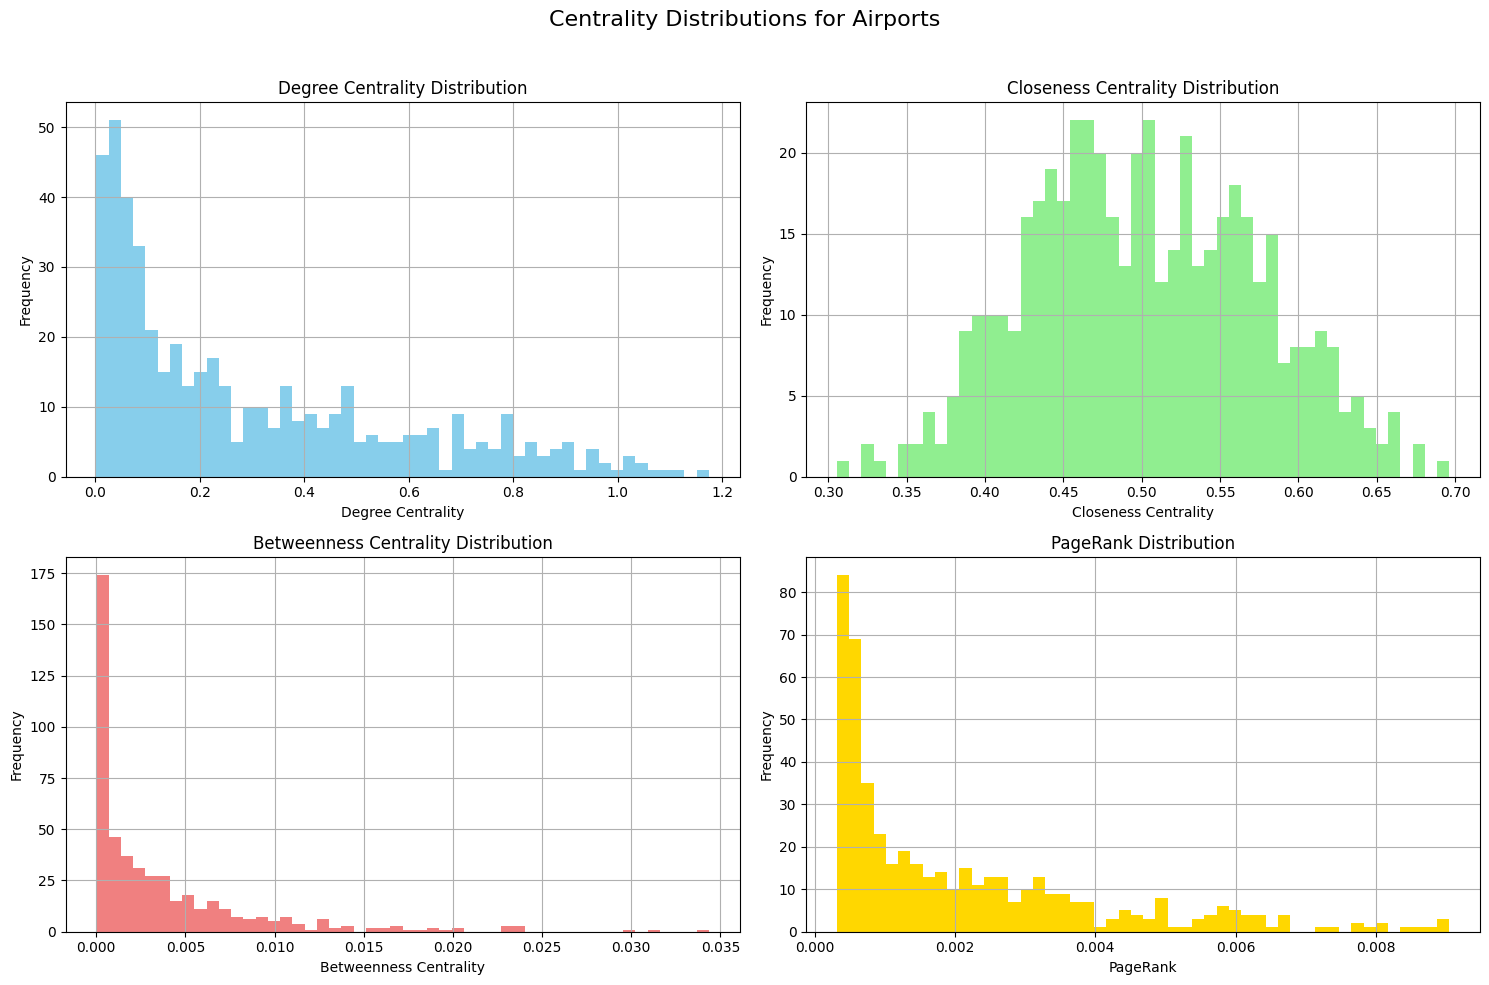

{'Top Degree Centrality':     Airport  Degree Centrality
 100     MSP           1.174274
 184     YIP           1.122407
 127     MEM           1.085062
 115     ORD           1.062241
 171     ATL           1.056017,
 'Top Closeness Centrality':     Airport  Closeness Centrality
 100     MSP              0.696407
 127     MEM              0.676366
 184     YIP              0.676366
 132     IND              0.664886
 124     STL              0.663011,
 'Top Betweenness Centrality':     Airport  Betweenness Centrality
 100     MSP                0.034353
 127     MEM                0.031565
 96      MCI                0.029859
 32      SLC                0.023504
 40      ABQ                0.023485,
 'Top PageRank':     Airport  PageRank
 7       LAX  0.009047
 42      LAS  0.009043
 100     MSP  0.008964
 23      PHX  0.008760
 240     MIA  0.008655}

In [21]:
compare_centralities(graph)

3. Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?

here is the output of ChatGpt:
| **Centrality Measure**         | **Relevance**                                                | **When to Use**                          |
|--------------------------------|-------------------------------------------------------------|------------------------------------------|
| **Eigenvector Centrality**     | Importance based on connections to influential nodes.       | Identify hubs connected to other hubs.   |
| **Katz Centrality**            | Balances influence of hubs and smaller nodes.               | Highlight strategic regional airports.   |
| **Harmonic Centrality**        | Accounts for disconnected nodes.                            | Sparse or disconnected networks.         |
| **Load Centrality**            | Measures flow through nodes.                                | Critical intermediaries for traffic.     |
| **Clustering Coefficient**     | Tendency to form local, tight clusters.                     | Identify regional clusters of routes.    |
| **Edge Betweenness Centrality**| Identifies critical edges in the network.                   | Find key flight routes.                  |
| **Strength Centrality**        | Weighted degree: accounts for passenger/traffic volume.     | Identify traffic-heavy airports.         |


to check his reliability we can check with a correlation methods to compare the centrality scores

4. Implement one of these measures suggested by the LLM, compare its results to the centralities you've already computed, and analyze whether it adds any new insights.

In [30]:
import networkx as nx
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

def calculate_alternative_centralities(flight_network):
    """
    Calculate Degree Centrality and Eigenvector Centrality for a given graph.
    Returns a DataFrame with centrality measures.
    """
    # Degree Centrality
    degree_centrality = nx.degree_centrality(flight_network)

    # Eigenvector Centrality
    eigenvector_centrality = nx.eigenvector_centrality(flight_network, weight='weight')

    # Create a DataFrame with centrality measures
    centrality_df2 = pd.DataFrame({
        'Airport': list(degree_centrality.keys()),
        'Degree Centrality': list(degree_centrality.values()),
        'Eigenvector Centrality': [eigenvector_centrality[node] for node in degree_centrality]
    })

    return centrality_df2

def plot_centrality_distributions(centrality_df):
    """
    Plot the distributions of Degree Centrality and Eigenvector Centrality.
    """
    plt.figure(figsize=(12, 5))

    # Degree Centrality Histogram
    plt.subplot(1, 2, 1)
    plt.hist(centrality_df['Degree Centrality'], bins=30, color='skyblue')
    plt.title('Degree Centrality Distribution')
    plt.xlabel('Degree Centrality')
    plt.ylabel('Frequency')

    # Eigenvector Centrality Histogram
    plt.subplot(1, 2, 2)
    plt.hist(centrality_df['Eigenvector Centrality'], bins=30, color='lightcoral')
    plt.title('Eigenvector Centrality Distribution')
    plt.xlabel('Eigenvector Centrality')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [33]:
centrality_df2=calculate_alternative_centralities(graph)

In [25]:
def test_centrality_correlation(centrality_df):
    degree = centrality_df['Degree Centrality']
    eigenvector = centrality_df['Eigenvector Centrality']

    #Spearman's rank correlation
    correlation, p_value = spearmanr(degree, eigenvector)

    print("Spearman's Rank Correlation between Degree and Eigenvector Centrality:")
    print(f"Correlation Coefficient: {correlation:.4f}")
    print(f"P-value: {p_value:.4e}")

    return correlation, p_value

In [34]:
test_centrality_correlation(centrality_df2)

Spearman's Rank Correlation between Degree and Eigenvector Centrality:
Correlation Coefficient: 0.9552
P-value: 1.9173e-256


(np.float64(0.9551831531163336), np.float64(1.9172640537759008e-256))

because the correlation coefficient its high (its maximum its 1) we can consider his output trustable

____
## **Finding Best Routes (Q3)**

- In this task, you need to implement a function that, given an origin and destination city, determines the best possible route between them. To simplify, the focus will be limited to flights operating on a specific day.

**Note**: Each city may have multiple airports; in such cases, the function should calculate the best route for every possible airport pair between the two cities. For example, if city A has airports $a_1$ , $a_2$ and city B has $b_1$ , $b_2$ , the function should compute the best routes for $a_1 → b_1$ , $a_1 → b_2$ , $a_2 → b_1$ and $a_2 → b_2$ . If it’s not possible to travel from one airport in the origin city to another airport in the destination city on that date, you must report it as well.

The function takes the following inputs:

1. Flights network

2. Origin city name

3. Destination city name

4. Considered Date (in yyyy-mm-dd format)

The function output:

1. A table with three columns: 'Origin_city_airport', 'Destination_city_airport', and the 'Best_route'.

**Note**: In the "Best_route" column, we expect a list of airport names connected by → , showing the order in which they are to be visited during the optimal route. If no such route exists, the entry should display "No route found."


> We choose the date with the most flights in the dataset

In [45]:
Date = df.groupby('Fly_date')['Origin_airport'].count().idxmax()
Date

'2007-12-01'

> After debug and analyzing our `distances_dictionary` from *Seattle*, we choose one of the routes with the highest `best_distance` in order to highlight the sequence of flights that brings to the destination. 

In [46]:
Origin_city = "Seattle"
Destination_city = "Bloomington"

> To compute the best route we can use the **Dijkstra's algorithm**.

#### **Dijkstra's algorithm**


Here it is a pseudocode:

1. Initialize a priority queue (min-heap) called '**pq**'

2. For each node in the graph:

    a. Set the distance to the source node as 0

    b. Set the distance to all other nodes as infinity

    c. Set the previous node for all nodes as undefined (None)

3. Insert the source node into the priority queue with distance 0

4. While the priority queue 'pq' is not empty:

    - Pop the node 'current' with the smallest distance from 'pq'

    - For each neighbor of the current node:

        - Calculate the new distance to the neighbor: ``` new_distance = current_distance + edge_weight```
        
        - If the new distance is smaller than the current known distance to the neighbor:

            - Update the shortest distance to this neighbor
            - Set the previous node to the current node
            - Insert the neighbor into the priority queue with the updated distance

5. After all nodes are processed, the algorithm ends.

6. The shortest path from the source to any node can be reconstructed by following the previous nodes.


**Function** `compute_best_route(graph, origin, destination, date)`

The Function `compute_best_route` computes the best route in a specific date between two cities.

- The graph is filtered using `filter_graph_by_date` function that creates a new graph adding only the edges relative to the input date

- Then we iterate over the all the pairs between the airports in the source and destination cities and minimize the distance between them using the `compute_Dijkstra` function. Since the Dijkstra algorithm computes a dictionary of distances from the minimized sources, we can apply it only once and then iterate over the number of airports in the destination city indexing in the `distances_dict`

- If the distance computed is less than the best_distance so update it and apply the `reconstruct_path` function where it builds the path to reach the destination iterating over the `prev` dictionary

- We return a Dataframe with all the infos needed

In [47]:
table = functions.compute_best_route(graph, Origin_city, Destination_city, Date)

# To hide the index of the row (only row of the dataframe)
table.style.hide(axis="index")

Origin_city_airport,Destination_city_airport,Best_route
Seattle,Bloomington,BFI->JFK->TCL->BDL->PWM->AVP->BMI


## **Airline Network Partitioning (Q4)**

- In graph theory, this task is known as a graph disconnection problem. Your goal is to write a function that removes the minimum number of flights between airports to separate the original flight network into two disconnected subgraphs.

## **Finding and Extracting Communities (Q5)**

1. In this task, you are asked to analyze the graph and identify the communities based on the flight network provided. For the airline, the primary focus is on the cities, so your communities should reflect the connectivity between cities through the flights that link them.

2. Ask a LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to suggest an alternative algorithm for extracting communities and explain the steps required to implement it. Then, implement this algorithm and compare its results with the current method you've chosen. Discuss the differences in the outcomes and analyze which approach you think is better, providing reasons for your choice.

## **Bonus Question - Connected Components on MapReduce**

1. In this task, you are required to use PySpark and the MapReduce paradigm to identify the connected components in a flight network graph. The focus should be on airports rather than cities. As you know, a connected component refers to a group of airports where every pair of airports within the group is connected either directly or indirectly.

2. Compare the execution time and the results of your implementation with those of the GraphFrames package for identifying connected components. If there is any difference in the results, provide an explanation for why that might occur.

## **Algorithmic Question (AQ)**

Arya needs to travel between cities using a network of flights. Each flight has a fixed cost (in euros), and she wants to find the cheapest possible way to travel from her starting city to her destination city. However, there are some constraints on the journey:

- Arya can make at most `k` stops during her trip (this means up to `k+1` flights).
    
- If no valid route exists within these constraints, the result should be `-1`.

Given a graph of cities connected by flights, your job is to find the minimum cost for Arya to travel between two specified cities (`src` to `dst`) while following the constraints.

**a)** Write a pseudocode that describes the algorithm to find the cheapest route with at most k stops.

**b)** Implement the algorithm in Python and simulate the given test cases.

**c)** Analyze the algorithm's efficiency. Provide its time complexity and space complexity, and explain whether it is efficient for large graphs (e.g., `n > 100`).

**d)** Optimize the algorithm to handle larger graphs. Provide an updated pseudocode and analyze the computational complexity of your optimization.

**e)** Ask LLM (e.g., ChatGPT) for an optimized version of your algorithm. Compare its solution to yours in terms of performance, time complexity, and correctness.